In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

In [2]:
# Funkcja do przekształcenia daty z ułamkowego roku na pełny rok i miesiąc
def convert_fractional_year(fractional_year):
    # Wyodrębnienie pełnego roku
    year = int(fractional_year)

    # Obliczenie części dziesiętnej i przekształcenie na miesiąc
    month_fraction = fractional_year - year
    month = int(round(month_fraction * 12)) + 1

    # Ustalenie pierwszego dnia miesiąca
    return pd.Timestamp(year=year, month=month, day=1)

In [47]:
def plot_predicted_vs_actual_advanced(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))

    # Obliczanie błędów
    errors = np.abs(y_test - y_pred)

    # Rysowanie rzeczywistych vs przewidywanych z gradientem kolorów na podstawie błędów
    scatter = plt.scatter(y_test, y_pred, c=errors, cmap='viridis', alpha=0.6, label='Przewidywane', marker='x')

    # Dodanie paska kolorów dla błędów
    cbar = plt.colorbar(scatter)
    cbar.set_label('The size of the measurement error')

    # Rysowanie linii idealnego dopasowania (y = x)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Idealne dopasowanie (y = x)')

    # Tytuł, etykiety osi i legenda
    plt.title(f'Predicted: {model_name}')
    plt.xlabel('Real values')
    plt.ylabel('Predicted values')
    plt.legend()
    plt.grid(True)

    plt.show()

In [4]:
#Wczytanie zbioru danych
df = pd.read_csv('real_estate.csv')
df_original = df.copy()

In [5]:
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [6]:
df.rename(columns={
    'Y house price of unit area': 'Price',
    'X1 transaction date': 'Transaction_Date',
    'X2 house age': 'House_Age',
    'X3 distance to the nearest MRT station': 'Distance_to_MRT',
    'X4 number of convenience stores': 'Convenience_Stores',
    'X5 latitude': 'Latitude',
    'X6 longitude': 'Longitude'
    }, inplace=True)

In [7]:
df.describe()

,No,Transaction_Date,House_Age,Distance_to_MRT,Convenience_Stores,Latitude,Longitude,Price
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,1.000000,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,104.250000,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [8]:
print(df.isnull().sum())

No                    0
Transaction_Date      0
House_Age             0
Distance_to_MRT       0
Convenience_Stores    0
Latitude              0
Longitude             0
Price                 0
dtype: int64


In [9]:
print((df == 0).sum())

No                     0
Transaction_Date       0
House_Age             17
Distance_to_MRT        0
Convenience_Stores    67
Latitude               0
Longitude              0
Price                  0
dtype: int64


In [10]:
# Przekształcenie kolumny 'X1 transaction date' z ułamkowego roku na pełną datę
df['Transaction_Date'] = df['Transaction_Date'].apply(convert_fractional_year)

# Wyodrębnianie roku, miesiąca i dnia tygodnia z przekształconej daty
df['Year'] = df['Transaction_Date'].dt.year
df['Month'] = df['Transaction_Date'].dt.month

df.drop(columns=['Transaction_Date'], inplace=True)

# Sprawdzenie przekształceń
print(df.head())

   No  House_Age  Distance_to_MRT  Convenience_Stores  Latitude  Longitude  \
0   1       32.0         84.87882                  10  24.98298  121.54024   
1   2       19.5        306.59470                   9  24.98034  121.53951   
2   3       13.3        561.98450                   5  24.98746  121.54391   
3   4       13.3        561.98450                   5  24.98746  121.54391   
4   5        5.0        390.56840                   5  24.97937  121.54245   

   Price  Year  Month  
0   37.9  2012     12  
1   42.2  2012     12  
2   47.3  2013      8  
3   54.8  2013      7  
4   43.1  2012     11  


In [11]:
#rozbicie kolumny year na rok 2012 i 2013
df = pd.get_dummies(df, columns=['Year'], drop_first=False)
df = pd.get_dummies(df, columns=['Month'], drop_first=False)
# Sprawdzenie, jak wyglądają kolumny po przekształceniu
print(df.columns)

Index(['No', 'House_Age', 'Distance_to_MRT', 'Convenience_Stores', 'Latitude',
       'Longitude', 'Price', 'Year_2012', 'Year_2013', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_9', 'Month_10', 'Month_11', 'Month_12'],
      dtype='object')


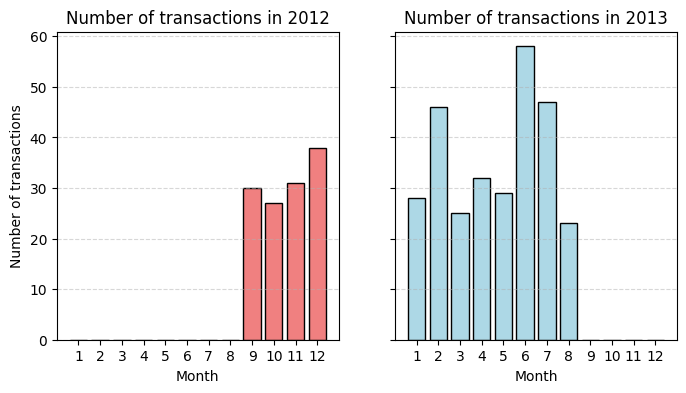

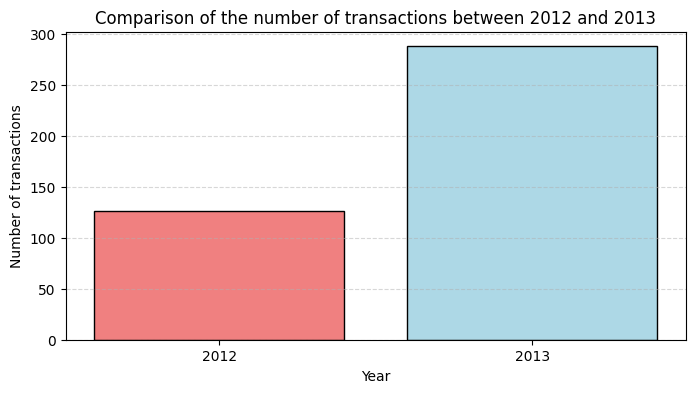

<Figure size 640x480 with 0 Axes>

In [17]:
# Liczba transakcji w poszczególnych miesiącach dla 2012 i 2013
monthly_transactions_2012 = [df[(df['Year_2012'] == 1) & (df[f'Month_{i}'] == 1)].shape[0] for i in range(1, 13)]
monthly_transactions_2013 = [df[(df['Year_2013'] == 1) & (df[f'Month_{i}'] == 1)].shape[0] for i in range(1, 13)]

# Tworzenie osobnych wykresów dla każdego roku
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# Wykres dla 2012 roku
axes[0].bar(range(1, 13), monthly_transactions_2012, color='lightcoral', edgecolor='black')
axes[0].set_title("Number of transactions in 2012")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Number of transactions")
axes[0].set_xticks(range(1, 13))
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Wykres dla 2013 roku
axes[1].bar(range(1, 13), monthly_transactions_2013, color='lightblue', edgecolor='black')
axes[1].set_title("Number of transactions in 2013")
axes[1].set_xlabel("Month")
axes[1].set_xticks(range(1, 13))
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# Liczba transakcji według roku (suma kolumn Year_2012 i Year_2013)
yearly_transactions = {
    "2012": df['Year_2012'].sum(),
    "2013": df['Year_2013'].sum()
}

# Wykres słupkowy liczby transakcji według roku
plt.figure(figsize=(8, 4))
plt.bar(yearly_transactions.keys(), yearly_transactions.values(), color=['lightcoral', 'lightblue'], edgecolor='black')
plt.title("Comparison of the number of transactions between 2012 and 2013")
plt.xlabel("Year")
plt.ylabel("Number of transactions")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Wyświetlenie wykresów
plt.tight_layout()
plt.show()

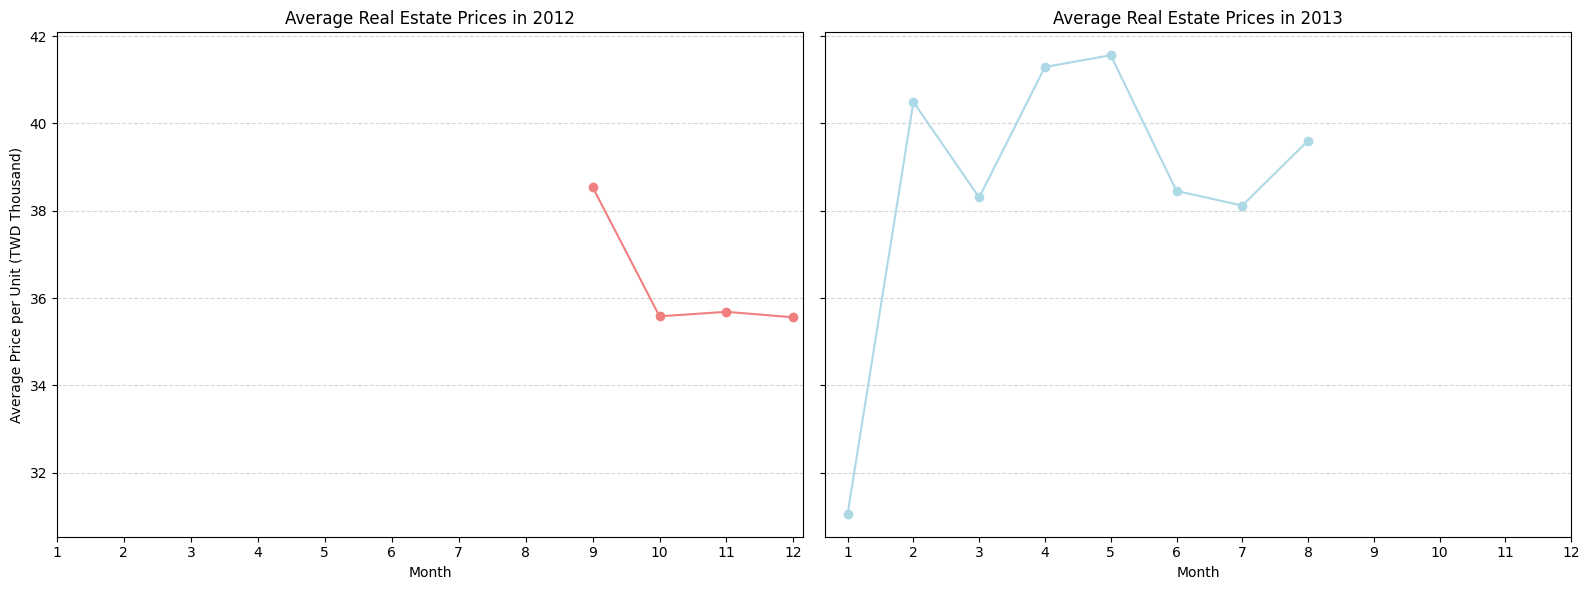

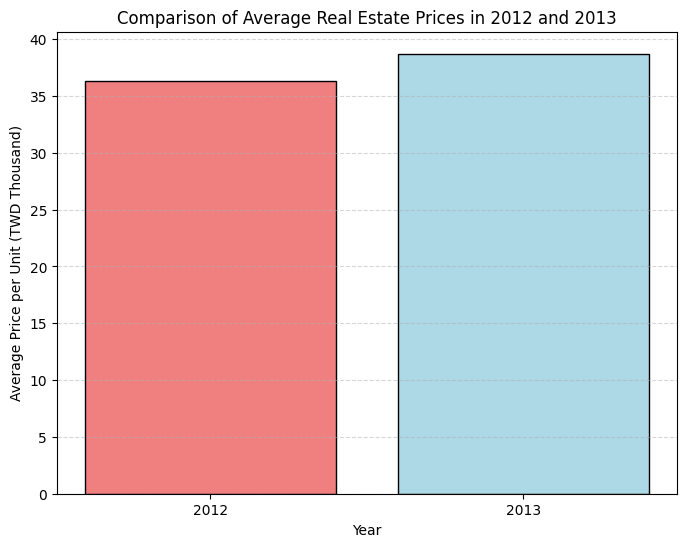

In [19]:
# Średnie ceny w poszczególnych miesiącach dla 2012 i 2013
monthly_avg_price_2012 = [df[(df['Year_2012'] == 1) & (df[f'Month_{i}'] == 1)]['Price'].mean() for i in range(1, 13)]
monthly_avg_price_2013 = [df[(df['Year_2013'] == 1) & (df[f'Month_{i}'] == 1)]['Price'].mean() for i in range(1, 13)]

# Wykresy średnich cen w poszczególnych miesiącach dla 2012 i 2013
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Wykres dla 2012 roku
axes[0].plot(range(1, 13), monthly_avg_price_2012, marker='o', color='lightcoral', linestyle='-', label='2012')
axes[0].set_title("Average Real Estate Prices in 2012")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Average Price per Unit (TWD Thousand)")
axes[0].set_xticks(range(1, 13))
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Wykres dla 2013 roku
axes[1].plot(range(1, 13), monthly_avg_price_2013, marker='o', color='lightblue', linestyle='-', label='2013')
axes[1].set_title("Average Real Estate Prices in 2013")
axes[1].set_xlabel("Month")
axes[1].set_xticks(range(1, 13))
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# Wyświetlenie wykresów
plt.tight_layout()
plt.show()

# Porównanie średnich cen w latach 2012 i 2013
avg_price_2012 = df[df['Year_2012'] == 1]['Price'].mean()
avg_price_2013 = df[df['Year_2013'] == 1]['Price'].mean()

# Wykres słupkowy porównujący średnie ceny w latach 2012 i 2013
plt.figure(figsize=(8, 6))
plt.bar(['2012', '2013'], [avg_price_2012, avg_price_2013], color=['lightcoral', 'lightblue'], edgecolor='black')
plt.title("Comparison of Average Real Estate Prices in 2012 and 2013")
plt.xlabel("Year")
plt.ylabel("Average Price per Unit (TWD Thousand)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

         Latitude   Longitude
count  414.000000  414.000000
mean    24.969030  121.533361
std      0.012410    0.015347
min     24.932070  121.473530
25%     24.963000  121.528085
50%     24.971100  121.538630
75%     24.977455  121.543305
max     25.014590  121.566270


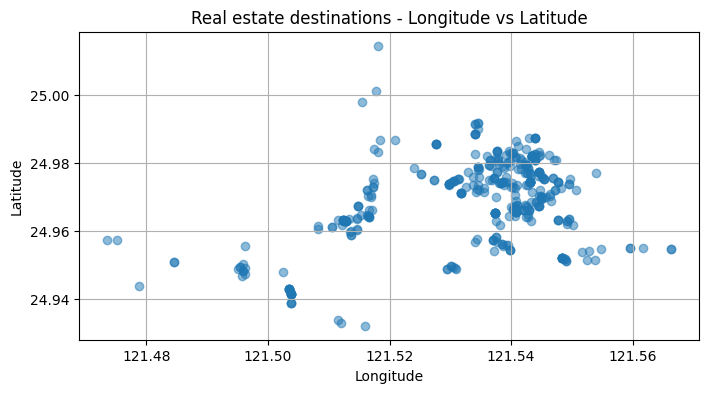

In [22]:
# Sprawdzenie podstawowych statystyk współrzędnych geograficznych
print(df[['Latitude', 'Longitude']].describe())

# Wykres rozrzutu dla współrzędnych geograficznych, aby zobaczyć ich rozmieszczenie


plt.figure(figsize=(8, 4))
plt.scatter(df['Longitude'], df['Latitude'], alpha=0.5)
plt.title("Real estate destinations - Longitude vs Latitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [24]:
# Obliczanie średniej współrzędnych w celu ustalenia współrzędnych skupiska (centrum)
centroid_latitude = df['Latitude'].mean()
centroid_longitude = df['Longitude'].mean()

# Punkt centralny na podstawie centroidu
centroid_point = (centroid_latitude.round(2), centroid_longitude.round(2))
print(f"Centroid (Mean): {centroid_point}")

Centroid (Mean): (24.97, 121.53)


In [25]:
# Użycie punktu centralnego z wybranego podejścia
central_point = centroid_point

# Obliczanie odległości od punktu centralnego
df['Distance_from_Center'] = df.apply(lambda row: geodesic((row['Latitude'], row['Longitude']), central_point).km, axis=1)

# Sprawdzenie wyniku
print(df[['Latitude', 'Longitude', 'Distance_from_Center']].head())

   Latitude  Longitude  Distance_from_Center
0  24.98298  121.54024              1.770974
1  24.98034  121.53951              1.494641
2  24.98746  121.54391              2.390230
3  24.98746  121.54391              2.390230
4  24.97937  121.54245              1.630209


In [26]:
df.drop(columns=['Latitude', 'Longitude','No'], inplace=True)

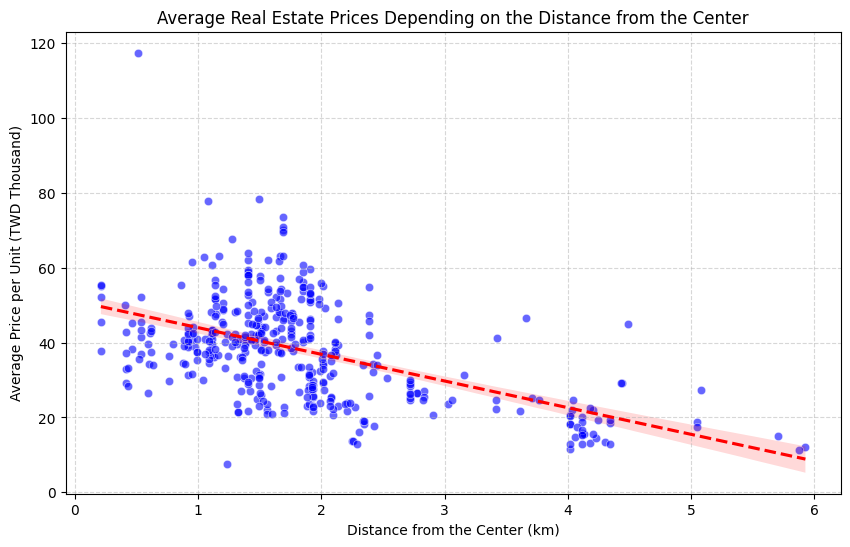

In [27]:
# Wykres rozrzutu: dystans od centrum vs cena nieruchomości
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Distance_from_Center', y='Price', data=df, alpha=0.6, color='blue')

# Dodanie linii trendu
sns.regplot(x='Distance_from_Center', y='Price', data=df, scatter=False, color='red', line_kws={"linestyle":"--"})

# Tytuł, etykiety osi i siatka
plt.title('Average Real Estate Prices Depending on the Distance from the Center')
plt.xlabel('Distance from the Center (km)')
plt.ylabel('Average Price per Unit (TWD Thousand)')
plt.grid(True, linestyle='--', alpha=0.5)

In [28]:
df.corr()

,House_Age,Distance_to_MRT,Convenience_Stores,Price,Year_2012,Year_2013,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Distance_from_Center
House_Age,1.000000,0.025622,0.049593,-0.210567,-0.049171,0.049171,0.002408,0.098228,0.027792,-0.006996,-0.027916,-0.032004,-0.039206,0.074520,0.022372,-0.050759,-0.112746,0.047733,-0.020392
Distance_to_MRT,0.025622,1.000000,-0.602519,-0.673613,-0.016519,0.016519,0.127889,-0.126710,-0.020352,-0.094699,-0.023027,-0.024050,0.171923,0.022394,-0.043776,-0.011104,0.052733,-0.025592,0.859286
Convenience_Stores,0.049593,-0.602519,1.000000,0.571005,0.005586,-0.005586,-0.119788,-0.000871,0.029797,0.058368,0.023380,0.055674,-0.073572,0.013740,0.086056,-0.028409,-0.093335,0.041006,-0.405945
Price,-0.210567,-0.673613,0.571005,1.000000,-0.081545,0.081545,-0.137202,0.065385,0.006040,0.070569,0.072337,0.014056,0.003659,0.028986,0.011582,-0.046621,-0.048072,-0.056664,-0.523394
Year_2012,-0.049171,-0.016519,0.005586,-0.081545,1.000000,-1.000000,-0.178145,-0.233854,-0.167681,-0.191440,-0.181534,-0.266980,-0.236704,-0.160422,0.422577,0.399335,0.430123,0.480628,-0.030497
Year_2013,0.049171,0.016519,-0.005586,0.081545,-1.000000,1.000000,0.178145,0.233854,0.167681,0.191440,0.181534,0.266980,0.236704,0.160422,-0.422577,-0.399335,-0.430123,-0.480628,0.030497
Month_1,0.002408,0.127889,-0.119788,-0.137202,-0.178145,0.178145,1.000000,-0.095223,-0.068278,-0.077952,-0.073919,-0.108711,-0.096383,-0.065322,-0.075280,-0.071140,-0.076624,-0.085622,0.182701
Month_2,0.098228,-0.126710,-0.000871,0.065385,-0.233854,0.233854,-0.095223,1.000000,-0.089629,-0.102329,-0.097034,-0.142707,-0.126523,-0.085749,-0.098821,-0.093386,-0.100586,-0.112397,-0.155306
Month_3,0.027792,-0.020352,0.029797,0.006040,-0.167681,0.167681,-0.068278,-0.089629,1.000000,-0.073373,-0.069577,-0.102326,-0.090722,-0.061485,-0.070858,-0.066961,-0.072123,-0.080592,-0.053759
Month_4,-0.006996,-0.094699,0.058368,0.070569,-0.191440,0.191440,-0.077952,-0.102329,-0.073373,1.000000,-0.079435,-0.116824,-0.103576,-0.070197,-0.080898,-0.076449,-0.082343,-0.092011,-0.083975


Wykresy z wartosciamy odstajacymi


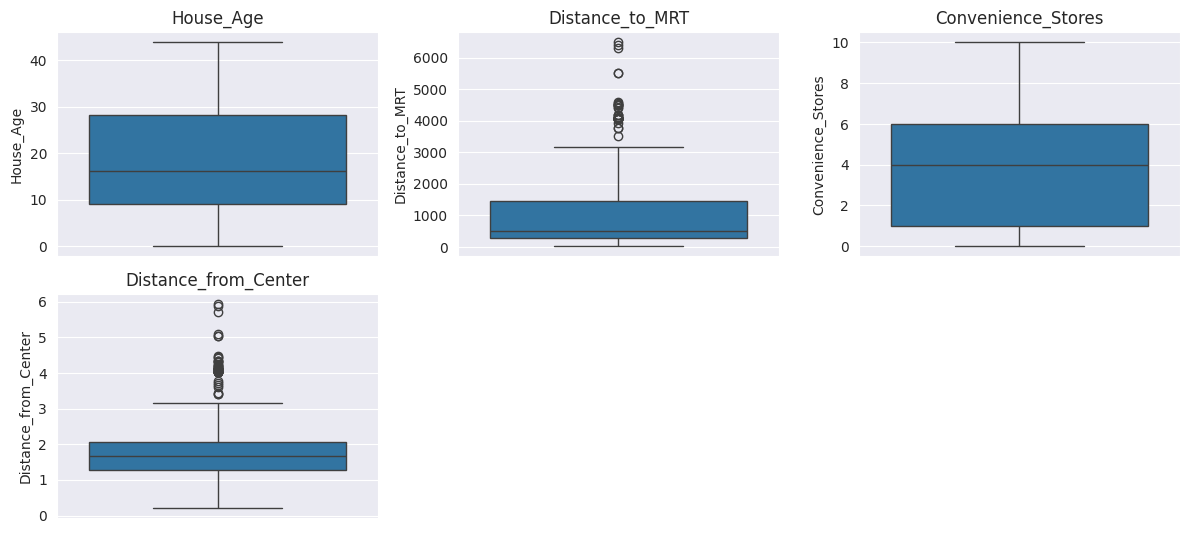

In [29]:
print('Wykresy z wartosciamy odstajacymi')
columns = ['House_Age', 'Distance_to_MRT', 'Convenience_Stores','Distance_from_Center']
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
for i, column in enumerate(columns):
    plt.subplot(3, 3, i + 1)  # 4 wiersze, 3 kolumny
    sns.boxplot(y=df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

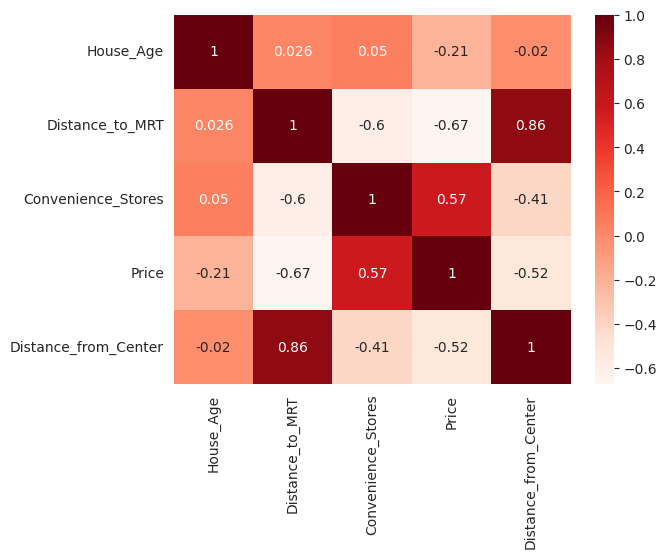

In [30]:
corr_matrix = df.drop(['Year_2012', 'Year_2013','Month_1','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12'], axis=1).corr()

sns.heatmap(corr_matrix, annot=True, cmap='Reds')
plt.show()

In [31]:
scaler = StandardScaler()

# Lista cech do skalowania bez zmiennej celu Price
features_to_scale = ['House_Age', 'Distance_to_MRT',
                     'Convenience_Stores', 'Distance_from_Center']

df_scaled = df.copy()

# Zastosowanie StandardScaler tylko do wybranych cech ciągłych
scaler = StandardScaler()
df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])

# Sprawdzenie wyników skalowania
print(df_scaled[features_to_scale].head())

   House_Age  Distance_to_MRT  Convenience_Stores  Distance_from_Center
0   1.255628        -0.792495            2.007407             -0.076308
1   0.157086        -0.616612            1.667503             -0.353198
2  -0.387791        -0.414015            0.307885              0.544195
3  -0.387791        -0.414015            0.307885              0.544195
4  -1.117223        -0.549997            0.307885             -0.217357


In [33]:
# Cechy (X) - wszystkie kolumny poza 'target' (nasza zmienna docelowa)
X = df_scaled.drop('Price', axis=1)

# Zmienna docelowa (y) - kolumna target
y = df_scaled['Price']

# Podzial na zbior testowy i treningowy 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"The size of the training set: {X_train.shape}")
print(f"The size of the test set: {X_test.shape}")

The size of the training set: (331, 18)
The size of the test set: (83, 18)


In [36]:
# Tworzenie modelu regresji liniowej
model = LinearRegression()

# Trenowanie modelu na zbiorze treningowym
model.fit(X_train, y_train)

# Dokonanie predykcji na zbiorze testowym
y_pred = model.predict(X_test)

# Ocena modelu
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"LinearRegression - R²: {r2:.2f}")
print(f"LinearRegression - Mean absolute error (MAE): {mae:.2f}")
print(f"LinearRegression - Mean root mean square error (RMSE): {rmse:.2f}")

LinearRegression - R²: 0.65
LinearRegression - Mean absolute error (MAE): 5.53
LinearRegression - Mean root mean square error (RMSE): 7.62


In [35]:
# Tworzenie modelu Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Trenowanie modelu na zbiorze treningowym
rf_model.fit(X_train, y_train)

# Dokonanie predykcji na zbiorze testowym
rf_pred = rf_model.predict(X_test)

# Ocena modelu
rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

print(f"Random Forest - R²: {rf_r2:.2f}")
print(f"Random Forest - Mean absolute error (MAE): {rf_mae:.2f}")
print(f"Random Forest - Mean root mean square error (RMSE): {rf_rmse:.2f}")

Random Forest - R²: 0.81
Random Forest - Mean absolute error (MAE): 4.17
Random Forest - Mean root mean square error (RMSE): 5.71


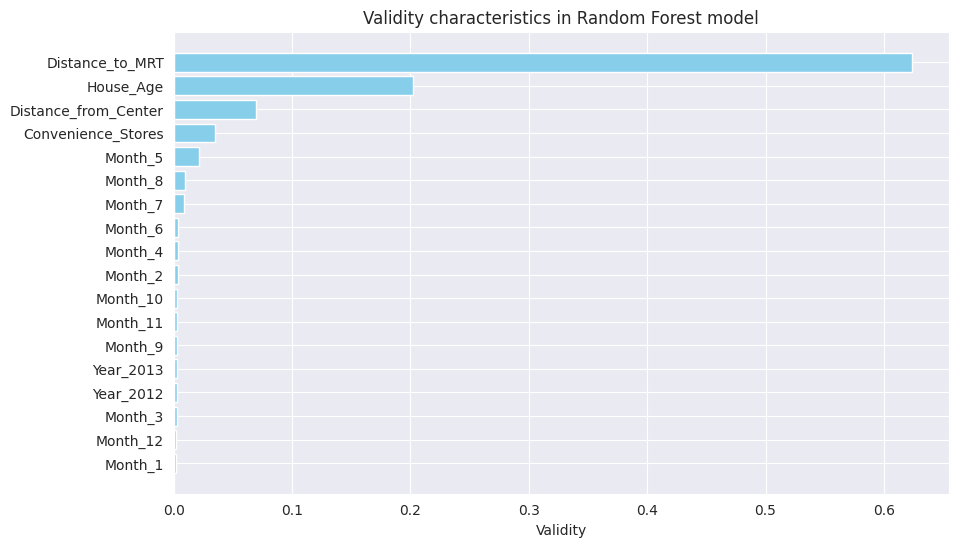

         Characteristics  Validity
1        Distance_to_MRT  0.623577
0              House_Age  0.201992
17  Distance_from_Center  0.069171
2     Convenience_Stores  0.034801
9                Month_5  0.021726
12               Month_8  0.009428
11               Month_7  0.008498
10               Month_6  0.004030
8                Month_4  0.003748
6                Month_2  0.003701
14              Month_10  0.003010
15              Month_11  0.002801
13               Month_9  0.002721
4              Year_2013  0.002664
3              Year_2012  0.002395
7                Month_3  0.002384
16              Month_12  0.001725
5                Month_1  0.001625


In [40]:
# Wyciągnięcie ważności cech z modelu Random Forest
feature_importances = rf_model.feature_importances_

# Tworzenie DataFrame do uporządkowania ważności cech
features = X_train.columns
importance_df = pd.DataFrame({'Characteristics': features, 'Validity': feature_importances})
importance_df = importance_df.sort_values(by='Validity', ascending=False)

# Wykres ważności cech
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Characteristics'], importance_df['Validity'], color='skyblue')
plt.xlabel('Validity')
plt.title('Validity characteristics in Random Forest model')
plt.gca().invert_yaxis()  # Odwrócenie osi, aby najważniejsze cechy były na górze
plt.grid(True)
plt.show()

# Wyświetlenie tabeli z ważnością cech
print(importance_df)

In [41]:
# Tworzenie modelu drzewa decyzyjnego
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Dokonanie predykcji i ocena modelu
dt_pred = dt_model.predict(X_test)

print(f"Decision Tree - R²: {r2_score(y_test, dt_pred):.2f}")
print(f"Decision Tree - MAE: {mean_absolute_error(y_test, dt_pred):.2f}")
print(f"Decision Tree - RMSE: {np.sqrt(mean_squared_error(y_test, dt_pred)):.2f}")

Decision Tree - R²: 0.56
Decision Tree - MAE: 5.92
Decision Tree - RMSE: 8.58


In [43]:
# Ustalamy zakresy hiperparametrów do przeszukania
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10]
}

# Tworzymy model Gradient Boosting
gbm_model = GradientBoostingRegressor(random_state=42)

# Randomized Search z 10-krotną walidacją krzyżową
random_search = RandomizedSearchCV(
    gbm_model, param_grid, n_iter=20, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
)

# Dopasowanie modelu do danych treningowych
random_search.fit(X_train, y_train)

# Najlepsze parametry
best_params = random_search.best_params_
print(f"Najlepsze parametry: {best_params}")

# Stworzenie modelu z najlepszymi parametrami
best_gbm_model = random_search.best_estimator_

# Dokonanie predykcji na zbiorze testowym
best_gbm_pred = best_gbm_model.predict(X_test)

# Ocena modelu
best_gbm_r2 = r2_score(y_test, best_gbm_pred)
best_gbm_mae = mean_absolute_error(y_test, best_gbm_pred)
best_gbm_rmse = np.sqrt(mean_squared_error(y_test, best_gbm_pred))

print(f"Gradient Boosting (Tuned) - R²: {best_gbm_r2:.2f}")
print(f"Gradient Boosting (Tuned) - MAE: {best_gbm_mae:.2f}")
print(f"Gradient Boosting (Tuned) - RMSE: {best_gbm_rmse:.2f}")

Najlepsze parametry: {'subsample': 0.7, 'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 3, 'learning_rate': 0.05}
Gradient Boosting (Tuned) - R²: 0.78
Gradient Boosting (Tuned) - MAE: 4.28
Gradient Boosting (Tuned) - RMSE: 6.08


In [44]:
# Tworzenie modelu XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Dokonanie predykcji i ocena modelu
xgb_pred = xgb_model.predict(X_test)

print(f"XGBoost - R²: {r2_score(y_test, xgb_pred):.2f}")
print(f"XGBoost - MAE: {mean_absolute_error(y_test, xgb_pred):.2f}")
print(f"XGBoost - RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred)):.2f}")

XGBoost - R²: 0.75
XGBoost - MAE: 4.70
XGBoost - RMSE: 6.54


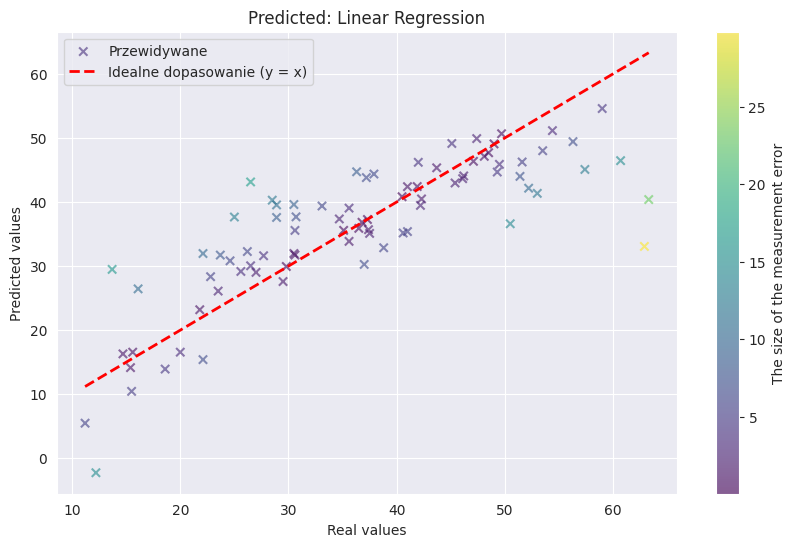

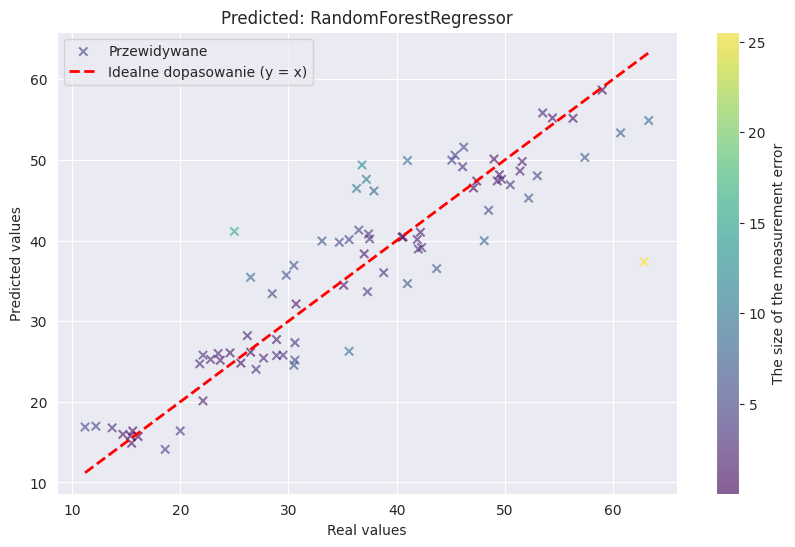

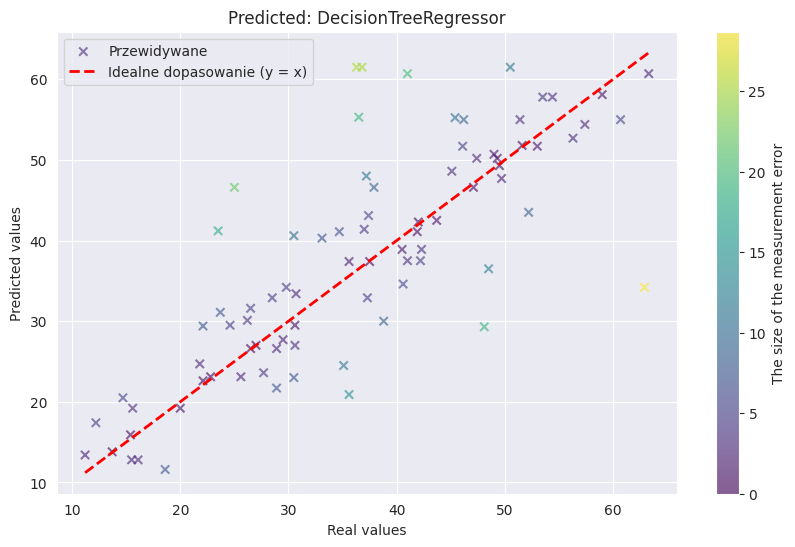

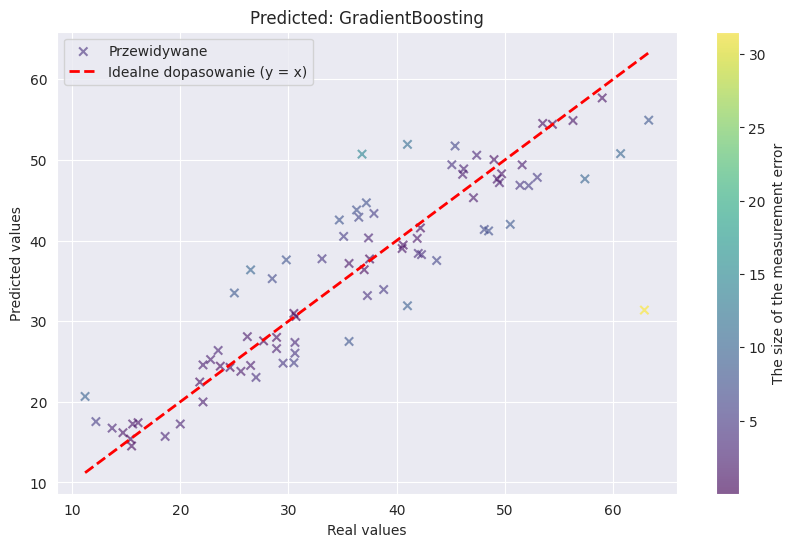

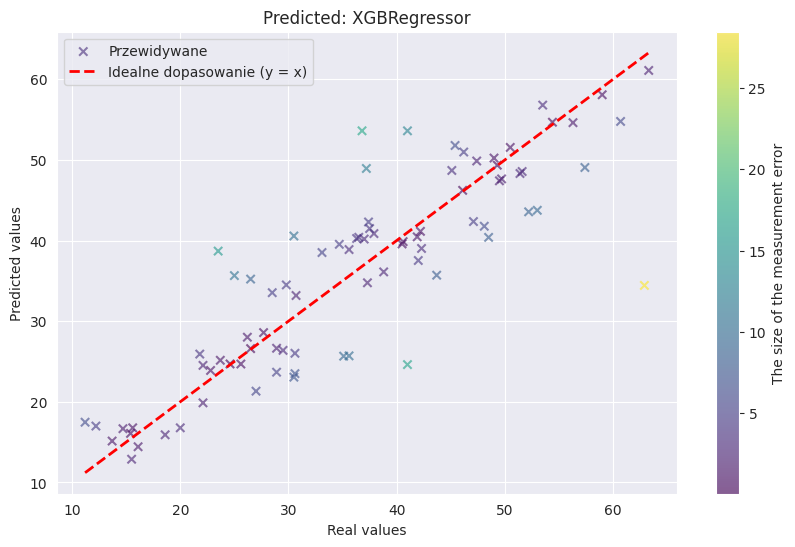

In [48]:
plot_predicted_vs_actual_advanced(y_test, y_pred, "Linear Regression")
plot_predicted_vs_actual_advanced(y_test, rf_pred, "RandomForestRegressor")
plot_predicted_vs_actual_advanced(y_test, dt_pred, "DecisionTreeRegressor")
plot_predicted_vs_actual_advanced(y_test, best_gbm_pred, "GradientBoosting")
plot_predicted_vs_actual_advanced(y_test, xgb_pred, "XGBRegressor")